# Making perdictions from fits images

In [6]:
import os
import tensorflow as tf
import numpy as np
from astropy.io import fits
import importlib.util

In [4]:
def load_module(path):
    spec = importlib.util.spec_from_file_location("module.name", path)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    return module

def load_arch(arch_path, bands):
    arch = load_module(arch_path)
    nn = arch.CNN()

    g = tf.Graph()
    with g.as_default():
        nn.create_architecture(bands=bands)
    return g, nn

def load_backup(sess, graph, backup):
    with graph.as_default():
        saver = tf.train.Saver()
        saver.restore(sess, backup)

## load invariant architecture and reload trained variables from a file

In [5]:
graph, nn = load_arch("arch_invariant.py", 1)
sess = tf.Session(graph=graph)
load_backup(sess, graph, 'trained_variables/space_based/invariant')

## load fits images

In [9]:
path = 'samples/space_based/lens/'
images = [fits.open(os.path.join(path, file))[0].data for file in os.listdir(path)]

path = 'samples/space_based/nolens/'
images += [fits.open(os.path.join(path, file))[0].data for file in os.listdir(path)]

images = nn.prepare(np.array(images).reshape((-1, 101, 101, 1)))

## make predictions

In [14]:
predictions = nn.predict(sess, images)
predictions

array([  9.99999881e-01,   1.00000000e+00,   1.00000000e+00,
         1.00000000e+00,   2.42116079e-02,   1.00000000e+00,
         1.00000000e+00,   1.00000000e+00,   1.51727011e-03,
         2.01962233e-04,   1.33235022e-04,   1.95607913e-06,
         2.34718973e-04,   6.48699206e-05,   1.13112328e-04,
         2.83246685e-04], dtype=float32)

### plot the images with the predictions

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

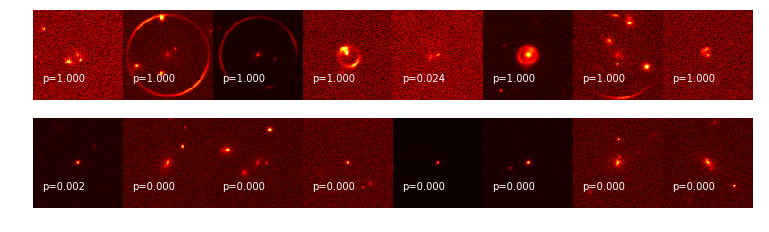

In [27]:
fig = plt.figure(figsize=(10,3))

for i in range(len(images)):
    a = fig.add_subplot(2, len(images) // 2,i+1)
    img = a.imshow(images[i, :, :, 0])
    img.set_cmap('hot')
    a.axis('off')
    a.annotate('p={:.3f}'.format(predictions[i]), xy=(10,80), color='white')

plt.subplots_adjust(left=0, bottom=0, top=1, right=1, wspace=0, hspace=0)